# Decision tree

Tenta criar regras de decisão através dos dados

- Consegue tratar não-linearidades
- Não sofre com a escala das features
- suporta variáveis categóricas e numéricas

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Dataset description
 - Features
    - CRIM - per capita crime rate by town
    - ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    - INDUS - proportion of non-retail business acres per town.
    - CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    - NOX - nitric oxides concentration (parts per 10 million)
    - RM - average number of rooms per dwelling
    - AGE - proportion of owner-occupied units built prior to 1940
    - DIS - weighted distances to five Boston employment centres
    - RAD - index of accessibility to radial highways
    - TAX - full-value property-tax rate per $10,000
    - PTRATIO - pupil-teacher ratio by town
    - B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - LSTAT - % lower status of the population
- Target
    - MEDV - Median value of owner-occupied homes in $1000's


## Default and functions definitions

In [2]:
plt.rcParams['figure.figsize'] = (10, 8)
for spine in ['top', 'right']:
    plt.rcParams[f'axes.spines.{spine}'] = False

RANDOM_STATE = 42

In [3]:
def load_dataset():
    X, y = load_boston(return_X_y=True)

    return train_test_split(X, y, random_state=RANDOM_STATE)


def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return rmse, mae, r2

## Dataset split

In [4]:
X_train, X_test, y_train, y_test = load_dataset()

columns = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
]
target = 'MEDV'
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

y_train = pd.DataFrame(y_train, columns=[target])
y_test = pd.DataFrame(y_test, columns=[target])

## Linear correlation viz

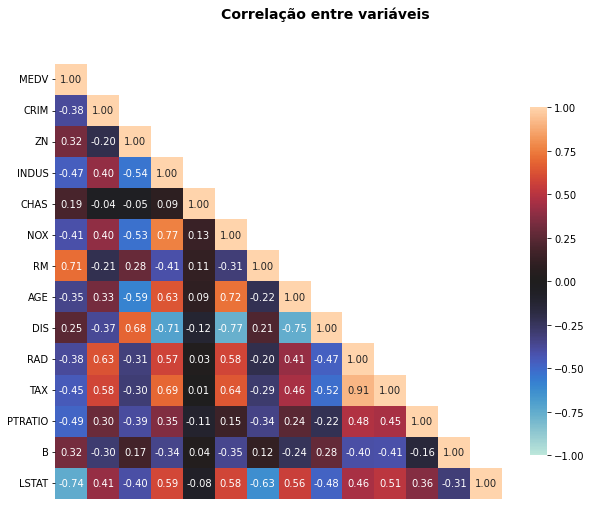

In [5]:
corr = pd.concat([y_train, X_train], axis=1).corr()
mask = np.triu(corr, k=1).astype(bool)
fig, ax = plt.subplots()
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, cbar_kws={'shrink': 0.8},
    ax=ax, annot=True, xticklabels=False, fmt='.2f')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.suptitle("Correlação entre variáveis", fontweight='bold', fontsize=14);

## Decision tree

O pacote mais comum para utilização de modelos simples de árvore é o [scikit-learn](https://scikit-learn.org)

Como qualquer outro modelo de aprendizado de máquina, árvores podem sofrer de _overfitting_. Na maioria dos casos, isso acontece quando não limitamos o crescimento da árvore, liberando para que ela cresça ao máximo, possuindo ramos com uma única folha - que pode ser interpretado como uma condição que levou a caracterização de um único exemplo na base de dados, ou seja, um conjunto de regras extremamente específico que provavelmente não possui nenhuma informação geral sobre a base de dados. Para evitar, podemos "podar" a árvore. Utilizando scikit-learn, conseguimos facilmente fazer isso com os parâmetros:

- `max_depth`: profundidade máxima da árvore;
- `min_samples_split`: quantidade mínima de exemplos em um ramo para que este possa se repartir em mais ramos ou folhas;
- `min_samples_leaf`: número mínimo presente em uma folha (final da regra). Como o valor _default_ é $1$, o _sklearn_ permite o crescimento de folhas de único exemplo, e isso pode causar _overfitting_;

Existem outros parâmetros que podem ser parametrizados também, mas ao meu ver, esses possuem maior influência sobre o _overfitting_.
Obs.: os outros parâmetros possuem influência sobre a performance global da árvore, como `min_weight_fraction_leaf`

In [6]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

(rmse, mae, r2) = eval_metrics(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 4.085146900277931
MAE: 2.808661417322835
R2: 0.761686335812318


## Interpretabilidade

É muito importante hoje termos noções boas de como os modelos "pensam". Não basta apensa construir o melhor modelo, mas é preciso também passar a forma como o modelo chega na decisão. Um ponto muito bom de modelos de árvores simples é a questão de fácil interpretação.

Facilmente podemos analisar:

- importância de cada uma das _features_;
- plotar a árvore

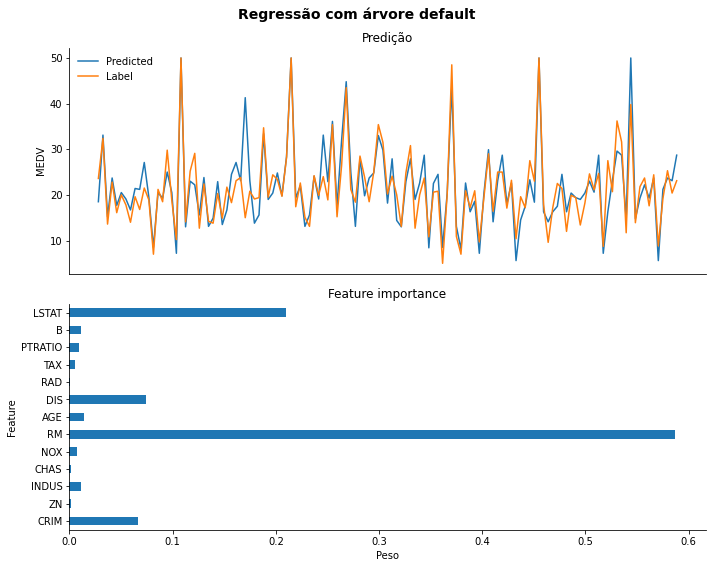

In [7]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(y_pred, label='Predicted')
ax[0].plot(y_test, label='Label')
ax[0].legend(frameon=False)
ax[0].set_xlabel("")
ax[0].set_xticks([])
ax[0].set_ylabel(target)
ax[0].set_title("Predição")
pd.DataFrame(tree.feature_importances_, index=X_train.columns).plot(kind='barh', ax=ax[1], legend=False)
ax[1].set_xlabel("Peso")
ax[1].set_ylabel("Feature")
ax[1].set_title("Feature importance")
plt.suptitle("Regressão com árvore default", fontweight='bold', fontsize=14)
plt.tight_layout();

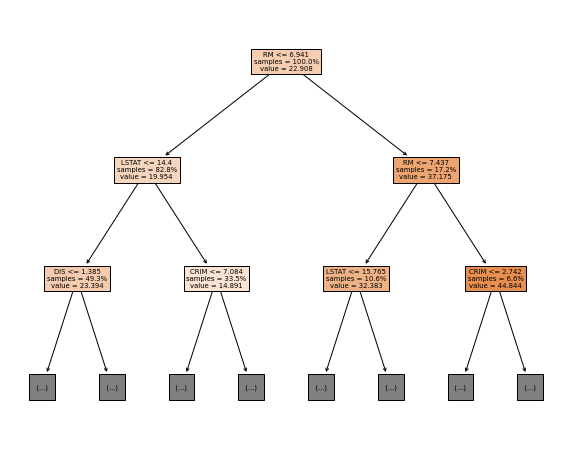

In [8]:
from sklearn.tree import plot_tree

plot_tree(tree,
          feature_names=X_train.columns,
          max_depth=2,  # nossa árvore é muito grande, por isso travamos o plot em duas repartições apenas
          filled=True, proportion=True, impurity=False);